In [ ]:
from transformers import LayoutLMv2FeatureExtractor, LayoutLMv2Tokenizer, LayoutLMv2Processor

feature_extractor = LayoutLMv2FeatureExtractor()
tokenizer = LayoutLMv2Tokenizer.from_pretrained("microsoft/layoutlmv2-base-uncased")
processor = LayoutLMv2Processor(feature_extractor, tokenizer)

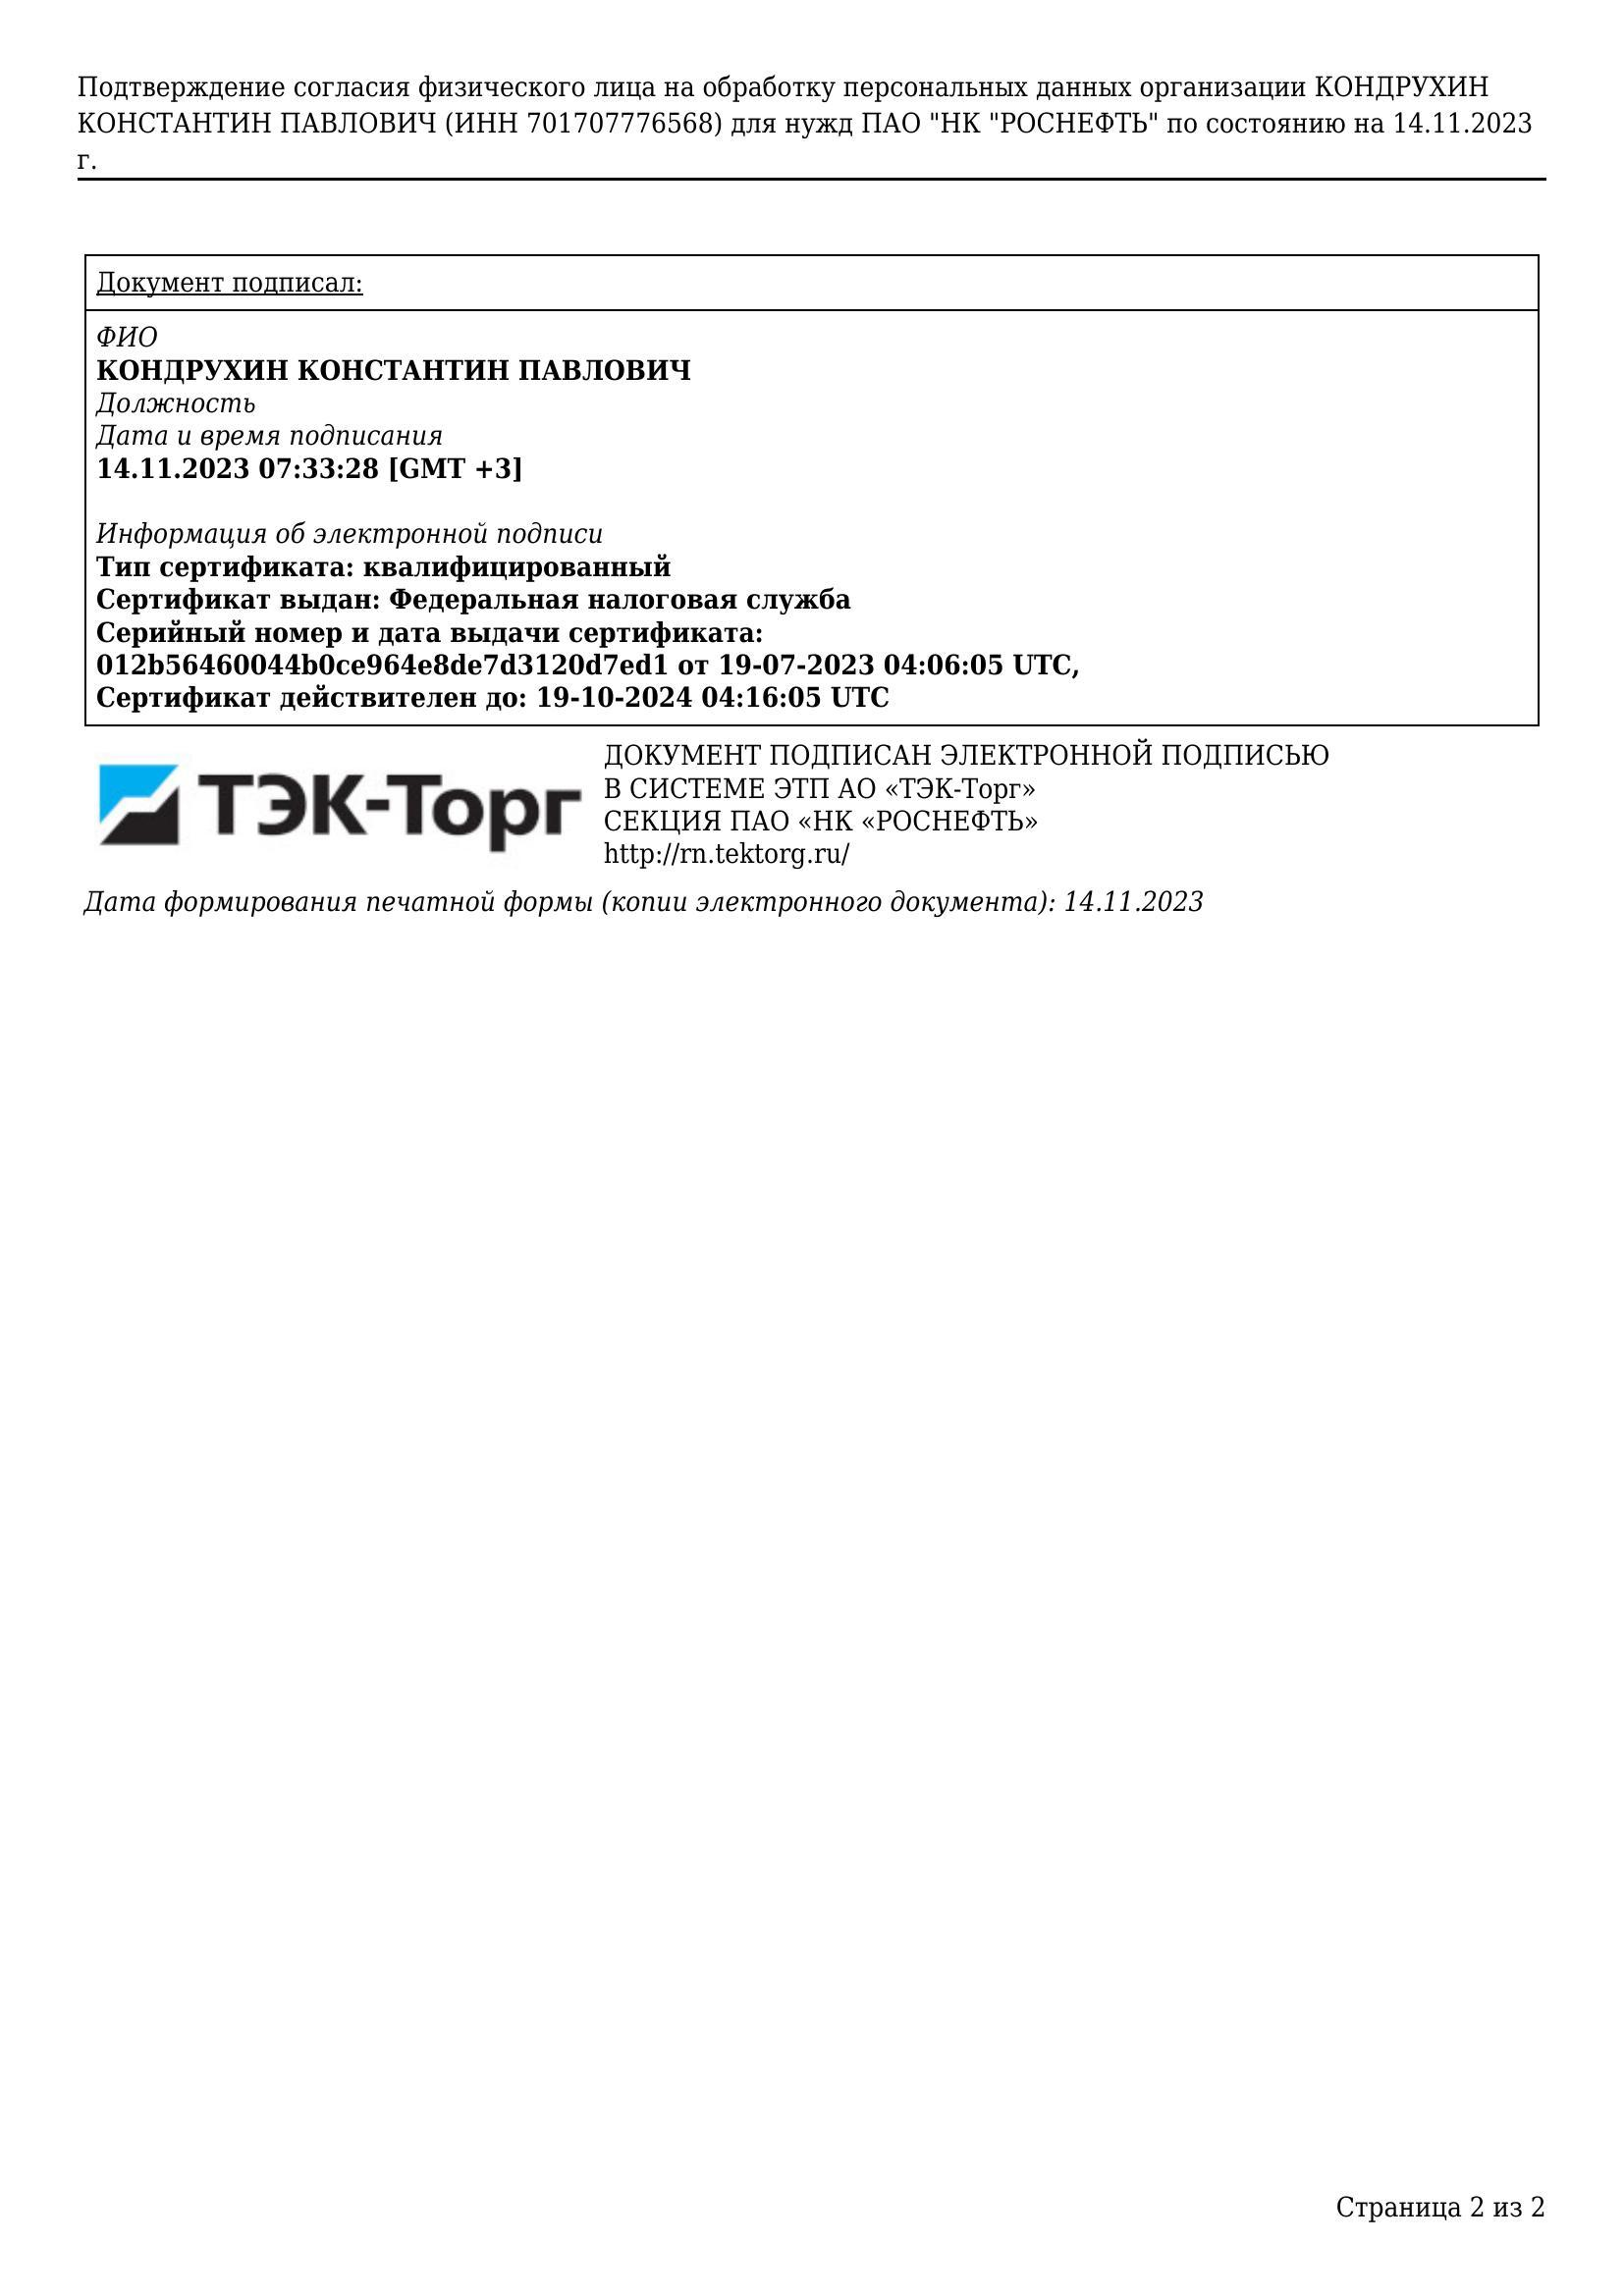

In [10]:
from PIL import Image, ImageDraw, ImageFont

image = Image.open("./pic1/4.jpg")
image = image.convert("RGB")
image

In [11]:
encoded_inputs = processor(image, return_tensors="pt")
for k,v in encoded_inputs.items():
  print(k, v.shape)

input_ids torch.Size([1, 422])
bbox torch.Size([1, 422, 4])
token_type_ids torch.Size([1, 422])
attention_mask torch.Size([1, 422])
image torch.Size([1, 3, 224, 224])


In [ ]:
encoded_inputs['input_ids']

In [ ]:
processor.tokenizer.decode(encoded_inputs.input_ids.squeeze().tolist())

# Начало

In [1]:
from PIL import Image, ImageDraw, ImageFont
from transformers import LayoutLMv2FeatureExtractor, LayoutLMv2Tokenizer, LayoutLMv2Processor
import os
import pandas as pd


In [2]:
feature_extractor = LayoutLMv2FeatureExtractor()
tokenizer = LayoutLMv2Tokenizer.from_pretrained("microsoft/layoutlmv2-base-uncased")
processor = LayoutLMv2Processor(feature_extractor, tokenizer)

/usr/local/lib/python3.10/dist-packages/transformers/models/layoutlmv2/feature_extraction_layoutlmv2.py:30: FutureWarning: The class LayoutLMv2FeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use LayoutLMv2ImageProcessor instead.
  warnings.warn(


In [3]:

data_dir = "output"
images = []
labels = []

for subdir in os.listdir(data_dir):
    for i in os.listdir(os.path.join(data_dir, subdir)):
        if '.png' in i:
            images.append(os.path.join(data_dir, subdir, i))
            labels.append(i.split('_')[0])
        if len(images) > 10:
            break




data = pd.DataFrame.from_dict({'image_path': images, 'label': labels})
# data.head()

In [4]:
from datasets import Dataset 

# read dataframe as HuggingFace Datasets object
dataset = Dataset.from_pandas(data)
dataset

Dataset({
    features: ['image_path', 'label'],
    num_rows: 15
})

In [9]:
inputs

NameError: name 'inputs' is not defined

In [5]:
from datasets import Features, Sequence, Value, Array2D, Array3D
# we need to define custom features
features = Features({
    'image': Array3D(dtype="int64", shape=(3, 224, 224)),
    'input_ids': Sequence(feature=Value(dtype='int64')),
    'attention_mask': Sequence(Value(dtype='int64')),
    'token_type_ids': Sequence(Value(dtype='int64')),
    'bbox': Array2D(dtype="int64", shape=(512, 4)),
    'labels': Value(dtype='float')  # метки для задачи регрессии
})

def preprocess_data(examples):
  # take a batch of images
  images = [Image.open(path).convert("RGB") for path in examples['image_path']]
  
  encoded_inputs = processor(images, padding="max_length", truncation=True)
  
  # add labels
  encoded_inputs["labels"] = [label for label in examples["label"]]

  return encoded_inputs

encoded_dataset = dataset.map(preprocess_data, remove_columns=dataset.column_names, features=features, 
                              batched=True, batch_size=2)

Map:   0%|          | 0/15 [00:00<?, ? examples/s]

In [6]:
encoded_dataset

Dataset({
    features: ['image', 'input_ids', 'attention_mask', 'token_type_ids', 'bbox', 'labels'],
    num_rows: 15
})

In [7]:
import torch
encoded_dataset.set_format(type="torch", device="cuda")

dataloader = torch.utils.data.DataLoader(encoded_dataset, batch_size=4)

In [8]:
from transformers import LayoutLMv2ForSequenceClassification
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = LayoutLMv2ForSequenceClassification.from_pretrained("microsoft/layoutlmv2-base-uncased", 
                                                            num_labels=1)
model.to(device)

ImportError: 
LayoutLMv2Model requires the detectron2 library but it was not found in your environment. Checkout the instructions on the
installation page: https://github.com/facebookresearch/detectron2/blob/master/INSTALL.md and follow the ones
that match your environment. Please note that you may need to restart your runtime after installation.


In [ ]:
from transformers import AdamW
from tqdm.notebook import tqdm

optimizer = AdamW(model.parameters(), lr=5e-5)

global_step = 0
num_train_epochs = 10
t_total = len(dataloader) * num_train_epochs # total number of training steps 

#put the model in training mode
model.train()
for epoch in range(num_train_epochs):
  print("Epoch:", epoch)
  running_loss = 0.0
  correct = 0
  for batch in tqdm(dataloader):
      # forward pass
      outputs = model(**batch)
      loss = outputs.loss

      running_loss += loss.item()
      predictions = outputs.logits.argmax(-1)
      correct += (predictions == batch['labels']).float().sum()

      # backward pass to get the gradients 
      loss.backward()

      # update
      optimizer.step()
      optimizer.zero_grad()
      global_step += 1
  
  print("Loss:", running_loss / batch["input_ids"].shape[0])
  accuracy = 100 * correct / len(data)
  print("Training accuracy:", accuracy.item())